**Author**: Andy Tzanidakis \
Last updated: May 14, 2024

## Overview



- Learn how to use VizieR TAP query to access tables and store/handle them in `LSDB`
- Learn how to use those catalogs and perform crossmatching with existing `LSDB` catalogs
- Pass HipsCat LSDB catalogs to `TAPE` to perform time-series analysis and exploration


In [1]:
# Standard library imports
import os

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import rcParams
import astropy.units as u
import dask
from dask.distributed import Client

# Local library-specific imports
import lsdb
from lsdb.core.search import BoxSearch, ConeSearch, PolygonSearch
from hipscat.inspection import plot_pixels
from hipscat.io.file_io import read_parquet_metadata
import tape
from tape import Ensemble, ColumnMapper

## ViZier and Aladin querying 
from pyvo import registry  # version >=1.4.1 
from mocpy import MOC
from ipyaladin import Aladin

# Jupyter-specific settings and magic commands
%matplotlib inline
%config InlineBackend.figure_format = "retina"

# Configuration settings
rcParams['savefig.dpi'] = 550
rcParams['font.size'] = 20
plt.rc('font', family='serif')
mpl.rcParams['axes.linewidth'] = 2

print(f'Version of lsdb is {lsdb.__version__}')
print(f'Version of TAPE is {tape.__version__}')

'Version of TAPE is 0.4.1'

## VizieR Querying

In [2]:
# TODO: explain what this particular catalog is and how did you find it
# the catalogue name in VizieR (Gaia DR3 part 6)
CATALOGUE = "I/360"

catalogue_ivoid = f"ivo://CDS.VizieR/{CATALOGUE}"

# the actual query to the registry
voresource = registry.search(ivoid=catalogue_ivoid)[0]

tables = voresource.get_tables()

In [3]:
# We can also extract the tables names for later use
tables_names = list(tables.keys())

In [4]:
print (f"Available table names: {tables_names}")

Available table names: ['I/360/syntphot', 'I/360/goldu', 'I/360/goldsp', 'I/360/goldsa', 'I/360/goldoba', 'I/360/goldf', 'I/360/goldc', 'I/360/binmass']


In [5]:
# Let's read quickly the table description...
voresource.describe(verbose=True)

Gaia DR3 Part 6. Performance verification
Short Name: I/360
IVOA Identifier: ivo://cds.vizier/i/360
Access modes: conesearch, hips#hips-1.0, tap#aux, web
Multi-capability service -- use get_service()

Gaia Data Release 3 (Gaia DR3) will be released on 13 June 2022. The Gaia DR3
catalogue builds upon the Early Data Release 3 (released on 3 December 2020)
and combines, for the same stretch of time and the same set of observations,
these already-published data products with numerous new data products such as
extended objects and non-single stars.

Waveband Coverage: optical

Source: 2022yCat.1360....0G
Authors: Gaia collaboration
Alternative identifier(s): doi:10.26093/cds/vizier.1360
More info: https://cdsarc.cds.unistra.fr/viz-bin/cat/I/360


In [6]:
# Select the first table name
table_name_1 = "I/360/goldf"
first_table_name = table_name_1

In [7]:
# Initialize tap service
tap_service = voresource.get_service("tap")
# Run a query to get the first 2000000 rows given a sky constraint (40x40 deg)
tap_records = voresource.get_service("tap").run_sync(f'SELECT TOP 2000000  * \
                            FROM "{first_table_name}" WHERE (DE_ICRS BETWEEN 0 and 40) AND (RA_ICRS BETWEEN 80 and 120)')

In [8]:
# Obtain table from TAP query
table0 = tap_records.to_table()

# Convert to pandas dataframe
table_df = table0.to_pandas()

In [9]:
print (f"Number of objects: {len(table_df)}")

Number of objects: 146151


Text(0, 0.5, 'DEC [deg]')

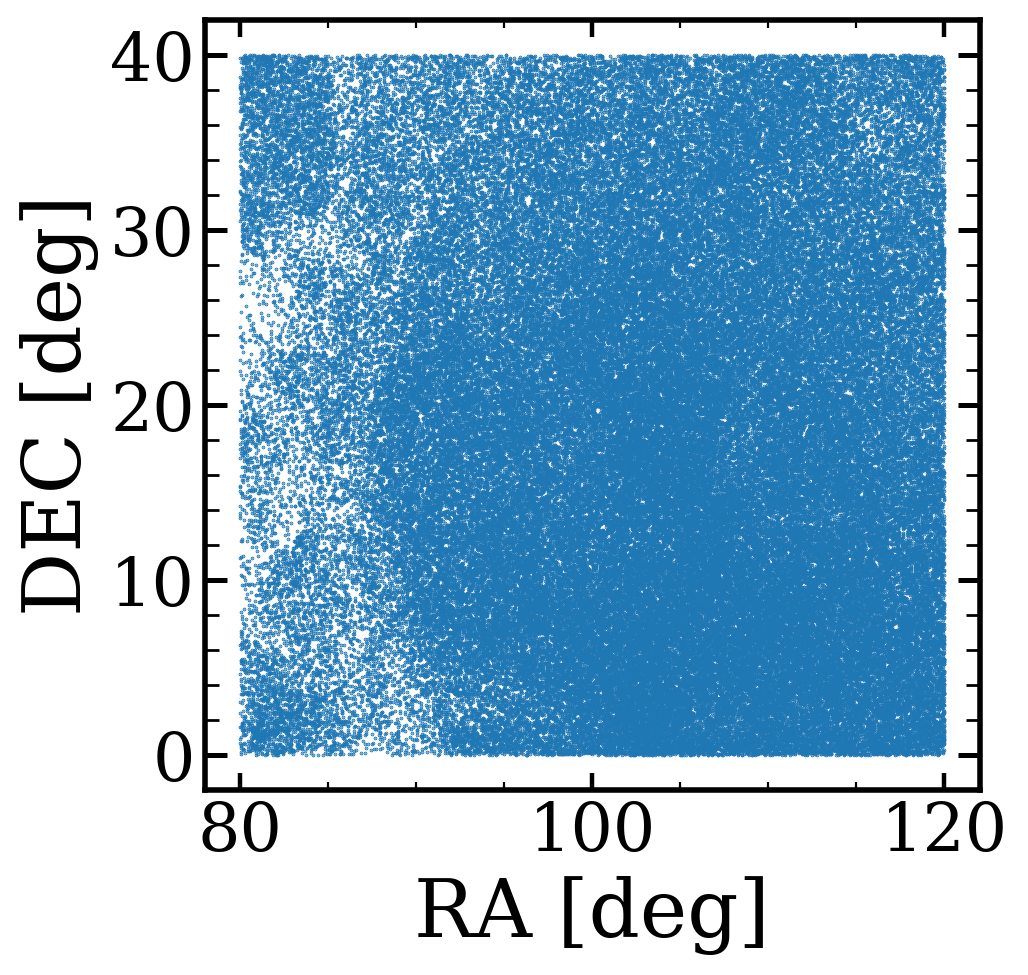

In [10]:
plt.figure(figsize=(5, 5))
plt.scatter(table_df['RA_ICRS'], table_df['DE_ICRS'], s=0.1)

plt.xlabel("RA [deg]")
plt.ylabel("DEC [deg]")

In [11]:
# select only M-type stars
table_df = table_df[table_df['SpType'].str.contains('M')]

In [12]:
table_df = table_df.drop(columns=['SpType'], axis=1)

In [13]:
print (f"Number of M-type stars: {len(table_df)}")

Number of M-type stars: 1304


In [14]:
# initialize dask client
client = Client(n_workers=2, threads_per_worker=1, memory_limit='12GiB')

/opt/miniconda3/envs/tape/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 51076 instead
  warnings.warn(


In [15]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:51076/status,
Dashboard: http://127.0.0.1:51076/status,Workers: 2
Total threads: 2,Total memory: 24.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:51077,Workers: 2
Dashboard: http://127.0.0.1:51076/status,Total threads: 2
Started: Just now,Total memory: 24.00 GiB
Comm: tcp://127.0.0.1:51084,Total threads: 1
Dashboard: http://127.0.0.1:51085/status,Memory: 12.00 GiB
Nanny: tcp://127.0.0.1:51080,


In [16]:
# shape of final data
# 1304 objects with 25 columns
np.shape(table_df)

(1304, 25)

In [17]:
table_df

,recno,Source,Teff-P,logg-P,[M/H]-P,AG-P,E(BP-RP)-P,[alphe/Fe]-S,Teff-S,logg-S,...,evol-F,Rad-FS,Lum-FS,Mass-FS,Age-FS,evol-FS,RA_ICRS,DE_ICRS,_RA_icrs,_DE_icrs
96,1302564,3414418568469105024,3537.0732,4.8277,-0.4692,1.0736,0.6528,NaN,NaN,NaN,...,<NA>,NaN,NaN,NaN,NaN,<NA>,80.069883,21.728261,80.069883,21.728261
97,404378,184080241020594432,3480.0610,4.9449,-0.4401,0.5360,0.3295,NaN,NaN,NaN,...,<NA>,NaN,NaN,NaN,NaN,<NA>,80.070542,36.902685,80.070542,36.902685
175,381376,181149939454121472,3762.3916,4.8400,-0.4543,0.4469,0.2548,NaN,NaN,NaN,...,<NA>,NaN,NaN,NaN,NaN,<NA>,80.125861,33.182380,80.125861,33.182380
197,1297228,3394452601243260416,3454.3877,4.9139,-0.5440,0.7279,0.4491,NaN,NaN,NaN,...,<NA>,NaN,NaN,NaN,NaN,<NA>,80.143190,17.118001,80.143190,17.118001
272,1303734,3421166821084053504,3654.8398,4.8564,-0.4198,0.4502,0.2642,NaN,NaN,NaN,...,<NA>,NaN,NaN,NaN,NaN,<NA>,80.202575,26.940224,80.202575,26.940224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144854,1179885,3146950751422274304,3597.1873,4.8924,-0.6316,0.4237,0.2492,NaN,NaN,NaN,...,<NA>,NaN,NaN,NaN,NaN,<NA>,119.667826,9.045320,119.667826,9.045320
144986,3012071,667216748460076288,3413.0269,5.0367,-0.5725,0.4808,0.2979,NaN,NaN,NaN,...,<NA>,NaN,NaN,NaN,NaN,<NA>,119.703423,16.671383,119.703423,16.671383
145260,1136349,3095215877477667584,3718.4084,4.7648,-0.4526,0.4189,0.2415,NaN,NaN,NaN,...,<NA>,NaN,NaN,NaN,NaN,<NA>,119.775527,4.460171,119.775527,4.460171
145606,3104491,681238923327469952,3700.2258,4.8012,-0.2501,0.2842,0.1659,NaN,NaN,NaN,...,<NA>,NaN,NaN,NaN,NaN,<NA>,119.856419,24.218425,119.856419,24.218425


In [18]:
table_df = table_df[['Teff-P', 'RA_ICRS', 'DE_ICRS', 'logg-P', 'Lum-F']]

In [19]:
table_df

,Teff-P,RA_ICRS,DE_ICRS,logg-P,Lum-F
96,3537.0732,80.069883,21.728261,4.8277,0.018851
97,3480.0610,80.070542,36.902685,4.9449,0.014007
175,3762.3916,80.125861,33.182380,4.8400,0.031608
197,3454.3877,80.143190,17.118001,4.9139,0.010928
272,3654.8398,80.202575,26.940224,4.8564,0.025514
...,...,...,...,...,...
144854,3597.1873,119.667826,9.045320,4.8924,0.016918
144986,3413.0269,119.703423,16.671383,5.0367,0.007080
145260,3718.4084,119.775527,4.460171,4.7648,0.032791
145606,3700.2258,119.856419,24.218425,4.8012,0.033940


In [20]:
%%time

catalogs_dir = "https://epyc.astro.washington.edu/~lincc-frameworks/hipscat_surveys"

gaia = lsdb.read_hipscat(f"{catalogs_dir}/gaia_dr3/gaia", columns=['ra', 'dec', 'parallax'],
 search_filter=ConeSearch(ra=100, dec=27.5, radius_arcsec=4*3600))

# load ZTF object table
ztf = lsdb.read_hipscat(f"{catalogs_dir}/ztf/ztf_dr14", columns=['ra', 'dec', 'ps1_objid'], 
search_filter=ConeSearch(ra=100, dec=27.5, radius_arcsec=4*3600))

# Load ZTF DR14 zources
ztf_sources = lsdb.read_hipscat(f"{catalogs_dir}/ztf/ztf_zource", columns=['ra', 'dec', 'mjd', 'mag', 'magerr', 'band', 'ps1_objid', 'catflags'], 
search_filter=ConeSearch(ra=100, dec=27.5, radius_arcsec=4*3600))

CPU times: user 844 ms, sys: 225 ms, total: 1.07 s
Wall time: 3.43 s


In [21]:
%%time
# Hipsccat VizieR table
# this takes around 3 minutes on my local machine
hips_object = lsdb.from_dataframe(
    table_df,
    catalog_name="golden",
    catalog_type="object",
    ra_column="RA_ICRS", 
    dec_column="DE_ICRS",
    lowest_order=5)

: 

In [ ]:
hips_object

,Teff-P,RA_ICRS,DE_ICRS,logg-P,Lum-F,Norder,Dir,Npix
npartitions=430,,,,,,,,
361413870096482304,float64,float64,float64,float64,float64,uint8,uint64,uint64
364791569817010176,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...
6916403127734239232,...,...,...,...,...,...,...,...
18446744073709551615,...,...,...,...,...,...,...,...


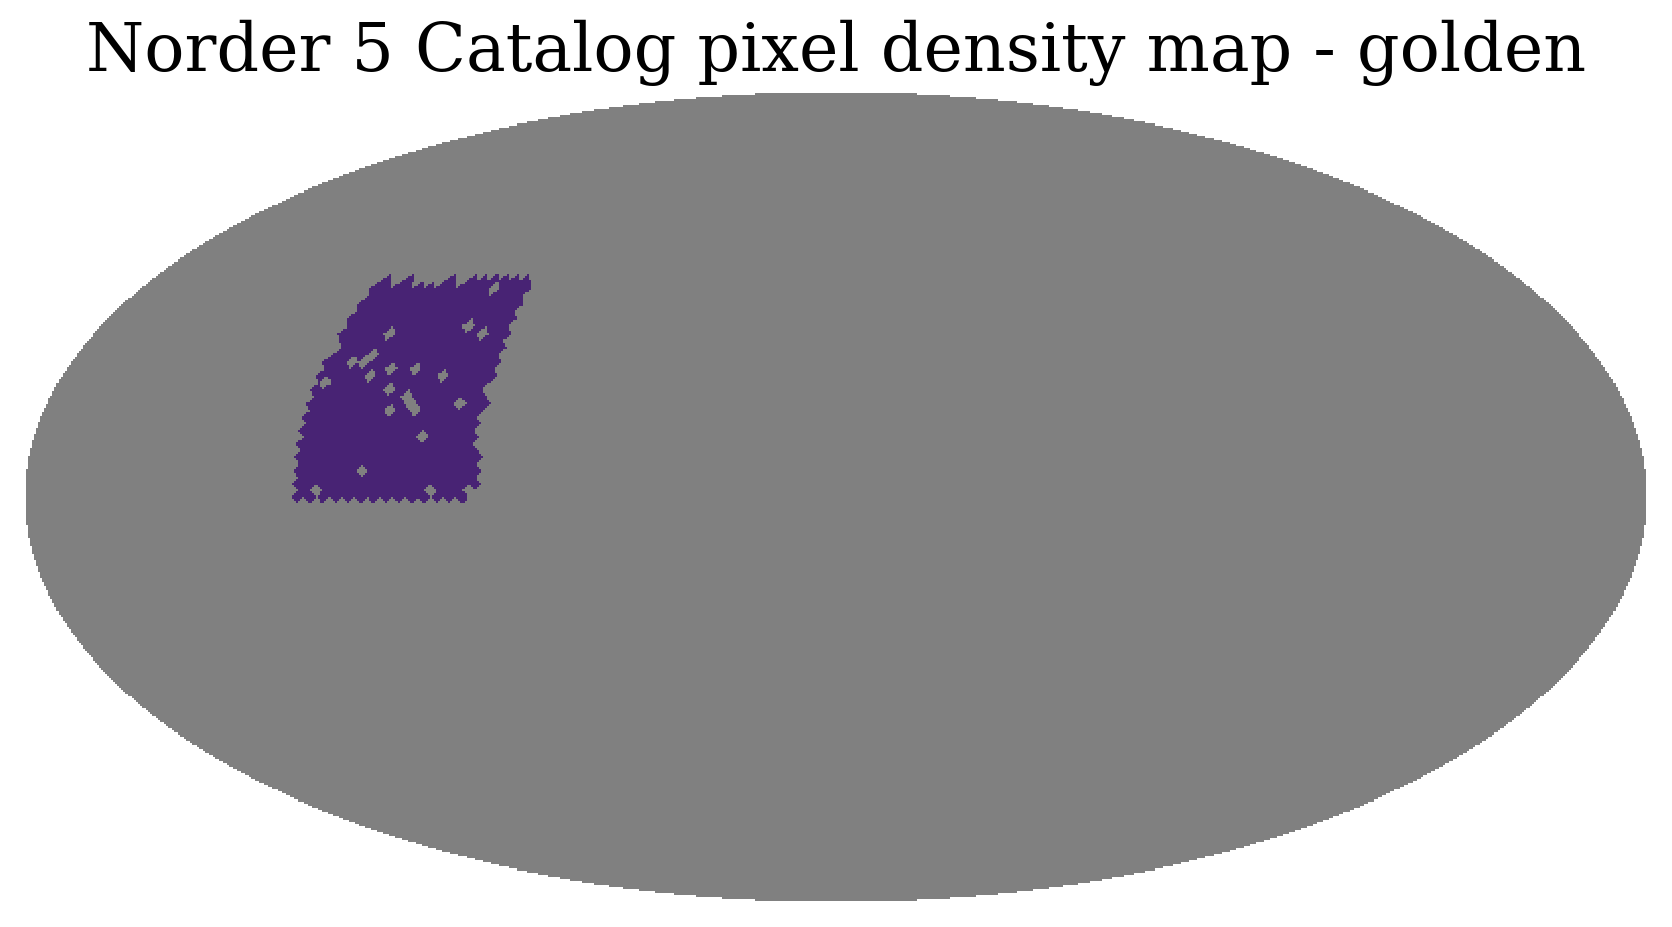

In [ ]:
from hipscat.inspection import plot_pixels
plot_pixels(hips_object.hc_structure)

In [ ]:
%%time
hips_object.head(1)

CPU times: user 21 ms, sys: 8.3 ms, total: 29.3 ms
Wall time: 43.9 ms


,Teff-P,RA_ICRS,DE_ICRS,logg-P,Lum-F,Norder,Dir,Npix
_hipscat_index,,,,,,,,
362299930204700672,3762.3916,80.125861,33.18238,4.84,0.031608,5,0,321


## Load Additional Catalogs

In [ ]:
# load ZTF source table

# load ZTF object table
#TODO: 
ztf = lsdb.read_hipscat(f"{catalogs_dir}/ztf/ztf_dr14",
                        columns=['ps1_objid', 'nobs_r', 'nobs_g', 'ra', 'dec'],
                          search_filter=ConeSearch(ra=100, dec=20, radius_arcsec=4*3600)) # select only Nobs (gr) bands

## Crossmatch

In [ ]:
hips_object

,Teff-P,RA_ICRS,DE_ICRS,logg-P,Lum-F,Norder,Dir,Npix
npartitions=430,,,,,,,,
361413870096482304,float64,float64,float64,float64,float64,uint8,uint64,uint64
364791569817010176,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...
6916403127734239232,...,...,...,...,...,...,...,...
18446744073709551615,...,...,...,...,...,...,...,...


In [ ]:
xmatch_golden_ztf_object = hips_object.crossmatch(ztf, 
                                                  n_neighbors=1, radius_arcsec=1, require_right_margin=False)

/home/camposandro/.conda/envs/lsdb-env/lib/python3.10/site-packages/lsdb/dask/crossmatch_catalog_data.py:117: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(


In [ ]:
xmatch_golden_ztf_object

,Teff-P_golden,RA_ICRS_golden,DE_ICRS_golden,logg-P_golden,Lum-F_golden,Norder_golden,Dir_golden,Npix_golden,ps1_objid_ztf_dr14,nobs_r_ztf_dr14,nobs_g_ztf_dr14,ra_ztf_dr14,dec_ztf_dr14,_dist_arcsec
npartitions=29,,,,,,,,,,,,,,
6710363444782039040,float64,float64,float64,float64,float64,uint8,uint64,uint64,int64,int32,int32,float64,float64,float64
6711489344688881664,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6767784340031012864,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18446744073709551615,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [ ]:
#xmatch_golden_ztf_object.dtypes

In [ ]:
#%%time
# Head of xmatch table with 250k rows for exploration
xmatch_golden_ztf_object.to_hipscat("test_hips")

In [ ]:
hips_object_v2 = lsdb.read_hipscat("test_hips")

In [ ]:
hips_object_v2

,Teff-P_golden,RA_ICRS_golden,DE_ICRS_golden,logg-P_golden,Lum-F_golden,Norder_golden,Dir_golden,Npix_golden,ps1_objid_ztf_dr14,nobs_r_ztf_dr14,nobs_g_ztf_dr14,ra_ztf_dr14,dec_ztf_dr14,_dist_arcsec
npartitions=29,,,,,,,,,,,,,,
6710363444782039040,float64,float64,float64,float64,float64,uint8,uint64,uint64,int64,int32,int32,float64,float64,float64
6711489344688881664,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6767784340031012864,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18446744073709551615,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [ ]:
hips_partition = hips_object_v2.compute()
hips_partition

,Teff-P_golden,RA_ICRS_golden,DE_ICRS_golden,logg-P_golden,Lum-F_golden,Norder_golden,Dir_golden,Npix_golden,ps1_objid_ztf_dr14,nobs_r_ztf_dr14,nobs_g_ztf_dr14,ra_ztf_dr14,dec_ztf_dr14,_dist_arcsec
_hipscat_index,,,,,,,,,,,,,,
6710565276456321024,3682.5994,98.162021,12.819634,4.8421,0.027456,5,0,5960,123380981620204010,991,329,98.162009,12.819666,0.125383
6712220008203681792,3636.6548,98.849947,14.428323,4.7430,0.046022,5,0,5961,125310988499434572,972,302,98.849939,14.428315,0.039755
6712315488854081536,3439.1160,98.995808,14.909210,4.8947,0.017644,5,0,5961,125890989957691554,938,302,98.995830,14.909237,0.124342
6711967842402566144,3545.6082,100.194500,14.577756,4.8585,0.019726,5,0,5961,125491001944763770,942,309,100.194493,14.577785,0.106754
6713572612347265024,3579.1555,97.222155,15.101648,4.8035,0.016656,5,0,5962,126120972221962503,970,318,97.222134,15.101665,0.093491
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6767806194540085248,3430.9675,98.603223,24.924794,4.9955,0.008787,5,0,6011,137910986032660304,898,265,98.603191,24.924821,0.141049
6767896241926832128,3306.3540,98.747871,25.291916,5.0318,0.005112,5,0,6011,138350987479630911,49,46,98.747814,25.291913,0.185012
6768306244630347776,3541.9602,99.146707,26.279128,4.8140,0.018149,5,0,6011,139530991466965546,903,271,99.146704,26.279135,0.027370


Text(0, 0.5, '$\\log_{10} L/L_\\odot$')

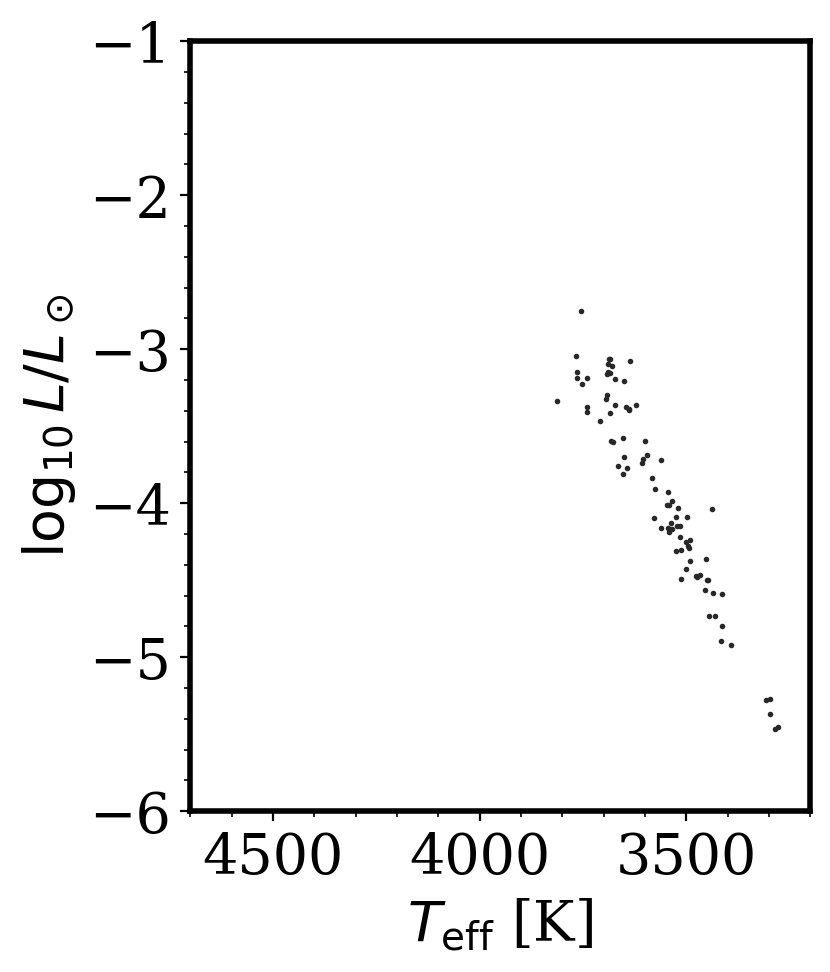

In [ ]:
plt.figure(figsize=(4, 5))
plt.scatter(hips_partition['Teff-P_golden'],
             np.log(hips_partition['Lum-F_golden']), s=1, 
             color='#28282B')
plt.xlim(plt.xlim(3200, 4700)[::-1])
plt.ylim(-6, -1)
plt.minorticks_on()
plt.xlabel(r"$T_{\rm eff}$ [K]")
plt.ylabel(r"$\log_{10} L/L_\odot$")

In [ ]:
%%time
# sync source catalog data to object (xmatched) object
_sources = hips_object_v2.join(
    ztf_sources, left_on="ps1_objid_ztf_dr14", right_on="ps1_objid")

CPU times: user 24.6 ms, sys: 640 µs, total: 25.2 ms
Wall time: 22 ms


/home/camposandro/.conda/envs/lsdb-env/lib/python3.10/site-packages/lsdb/dask/join_catalog_data.py:195: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(


In [ ]:
ztf_sources

,ra,dec,mjd,mag,magerr,band,ps1_objid,catflags
npartitions=84,,,,,,,,
1768225803696340992,float64,float64,float64,float32,float32,string,int64,int16
1774418253183975424,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...
6871930081413955584,...,...,...,...,...,...,...,...
18446744073709551615,...,...,...,...,...,...,...,...


In [ ]:
_sources

,Teff-P_golden_golden_x_ztf_dr14,RA_ICRS_golden_golden_x_ztf_dr14,DE_ICRS_golden_golden_x_ztf_dr14,logg-P_golden_golden_x_ztf_dr14,Lum-F_golden_golden_x_ztf_dr14,Norder_golden_golden_x_ztf_dr14,Dir_golden_golden_x_ztf_dr14,Npix_golden_golden_x_ztf_dr14,ps1_objid_ztf_dr14_golden_x_ztf_dr14,nobs_r_ztf_dr14_golden_x_ztf_dr14,nobs_g_ztf_dr14_golden_x_ztf_dr14,ra_ztf_dr14_golden_x_ztf_dr14,dec_ztf_dr14_golden_x_ztf_dr14,_dist_arcsec_golden_x_ztf_dr14,ra_ztf_zource,dec_ztf_zource,mjd_ztf_zource,mag_ztf_zource,magerr_ztf_zource,band_ztf_zource,ps1_objid_ztf_zource,catflags_ztf_zource
npartitions=23,,,,,,,,,,,,,,,,,,,,,,
6759058615752982528,float64,float64,float64,float64,float64,uint8,uint64,uint64,int64,int32,int32,float64,float64,float64,float64,float64,float64,float32,float32,string,int64,int16
6759340090729693184,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6768628764961144832,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18446744073709551615,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


## TAPE

In [ ]:
# Initialize an Ensemble
ens = Ensemble(client=client)

In [ ]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 2,Total memory: 24.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44369,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 2
Started: 1 minute ago,Total memory: 24.00 GiB
Comm: tcp://127.0.0.1:38665,Total threads: 1
Dashboard: http://127.0.0.1:39217/status,Memory: 12.00 GiB
Nanny: tcp://127.0.0.1:34713,


In [ ]:
_sources

,Teff-P_golden_golden_x_ztf_dr14,RA_ICRS_golden_golden_x_ztf_dr14,DE_ICRS_golden_golden_x_ztf_dr14,logg-P_golden_golden_x_ztf_dr14,Lum-F_golden_golden_x_ztf_dr14,Norder_golden_golden_x_ztf_dr14,Dir_golden_golden_x_ztf_dr14,Npix_golden_golden_x_ztf_dr14,ps1_objid_ztf_dr14_golden_x_ztf_dr14,nobs_r_ztf_dr14_golden_x_ztf_dr14,nobs_g_ztf_dr14_golden_x_ztf_dr14,ra_ztf_dr14_golden_x_ztf_dr14,dec_ztf_dr14_golden_x_ztf_dr14,_dist_arcsec_golden_x_ztf_dr14,ra_ztf_zource,dec_ztf_zource,mjd_ztf_zource,mag_ztf_zource,magerr_ztf_zource,band_ztf_zource,ps1_objid_ztf_zource,catflags_ztf_zource
npartitions=23,,,,,,,,,,,,,,,,,,,,,,
6759058615752982528,float64,float64,float64,float64,float64,uint8,uint64,uint64,int64,int32,int32,float64,float64,float64,float64,float64,float64,float32,float32,string,int64,int16
6759340090729693184,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6768628764961144832,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18446744073709551615,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [ ]:
# ColumnMapper Establishes which table columns map to timeseries quantities
colmap = ColumnMapper(
        id_col='_hipscat_index',
        time_col='mjd_ztf_zource',
        flux_col='mag_ztf_zource',
        err_col='magerr_ztf_zource',
        band_col='band_ztf_zource',
      )

ens.from_lsdb(
    source_catalog=_sources,
    object_catalog=hips_object_v2,
    column_mapper=colmap,
    sync_tables=False,
    sorted=True,
    sort=True)

In [ ]:
len(ens.source.columns)

22

In [ ]:
ens.source

,Teff-P_golden_golden_x_ztf_dr14,RA_ICRS_golden_golden_x_ztf_dr14,DE_ICRS_golden_golden_x_ztf_dr14,logg-P_golden_golden_x_ztf_dr14,Lum-F_golden_golden_x_ztf_dr14,Norder_golden_golden_x_ztf_dr14,Dir_golden_golden_x_ztf_dr14,Npix_golden_golden_x_ztf_dr14,ps1_objid_ztf_dr14_golden_x_ztf_dr14,nobs_r_ztf_dr14_golden_x_ztf_dr14,nobs_g_ztf_dr14_golden_x_ztf_dr14,ra_ztf_dr14_golden_x_ztf_dr14,dec_ztf_dr14_golden_x_ztf_dr14,_dist_arcsec_golden_x_ztf_dr14,ra_ztf_zource,dec_ztf_zource,mjd_ztf_zource,mag_ztf_zource,magerr_ztf_zource,band_ztf_zource,ps1_objid_ztf_zource,catflags_ztf_zource
npartitions=23,,,,,,,,,,,,,,,,,,,,,,
6759058615752982528,float64,float64,float64,float64,float64,uint8,uint64,uint64,int64,int32,int32,float64,float64,float64,float64,float64,float64,float32,float32,string,int64,int16
6759340090729693184,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6768628764961144832,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18446744073709551615,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [ ]:
ts = ens.to_timeseries(6759861235694436352)

In [ ]:
ts.data

Teff-P_golden_golden_x_ztf_dr14  RA_ICRS_golden_golden_x_ztf_dr14  \
band index                                                                      
r    0                            3739.6497                        101.372429   
     1                            3739.6497                        101.372429   
     2                            3739.6497                        101.372429   
     3                            3739.6497                        101.372429   
     4                            3739.6497                        101.372429   
...                                     ...                               ...   
     841                          3739.6497                        101.372429   
     842                          3739.6497                        101.372429   
     843                          3739.6497                        101.372429   
     844                          3739.6497                        101.372429   
     845                          3739.6497                        101.372429   

            DE_ICRS_golden_golden_x_ztf_dr14  logg-P_golden_golden_x_ztf_dr14  \
band index                                                                      
r    0                             24.326345                           4.8254   
     1                             24.326345                           4.8254   
     2                             24.326345                           4.8254   
     3                             24.326345                           4.8254   
     4                             24.326345                           4.8254   
...                                      ...                              ...   
     841                           24.326345                           4.8254   
     842                           24.326345                           4.8254   
     843                           24.326345                           4.8254   
     844                           24.326345                           4.8254   
     845                           24.326345                           4.8254   

            Lum-F_golden_golden_x_ztf_dr14  Norder_golden_golden_x_ztf_dr14  \
band index                                                                    
r    0                            0.033149                                5   
     1                            0.033149                                5   
     2                            0.033149                                5   
     3                            0.033149                                5   
     4                            0.033149                                5   
...                                    ...                              ...   
     841                          0.033149                                5   
     842                          0.033149                                5   
     843                          0.033149                                5   
     844                          0.033149                                5   
     845                          0.033149                                5   

            Dir_golden_golden_x_ztf_dr14  Npix_golden_golden_x_ztf_dr14  \
band index                                                                
r    0                                 0                           6003   
     1                                 0                           6003   
     2                                 0                           6003   
     3                                 0                           6003   
     4                                 0                           6003   
...                                  ...                            ...   
     841                               0                           6003   
     842                               0                           6003   
     843                               0                           6003   
     844                               0           

(16.621712122205643, 15.614585388358682)

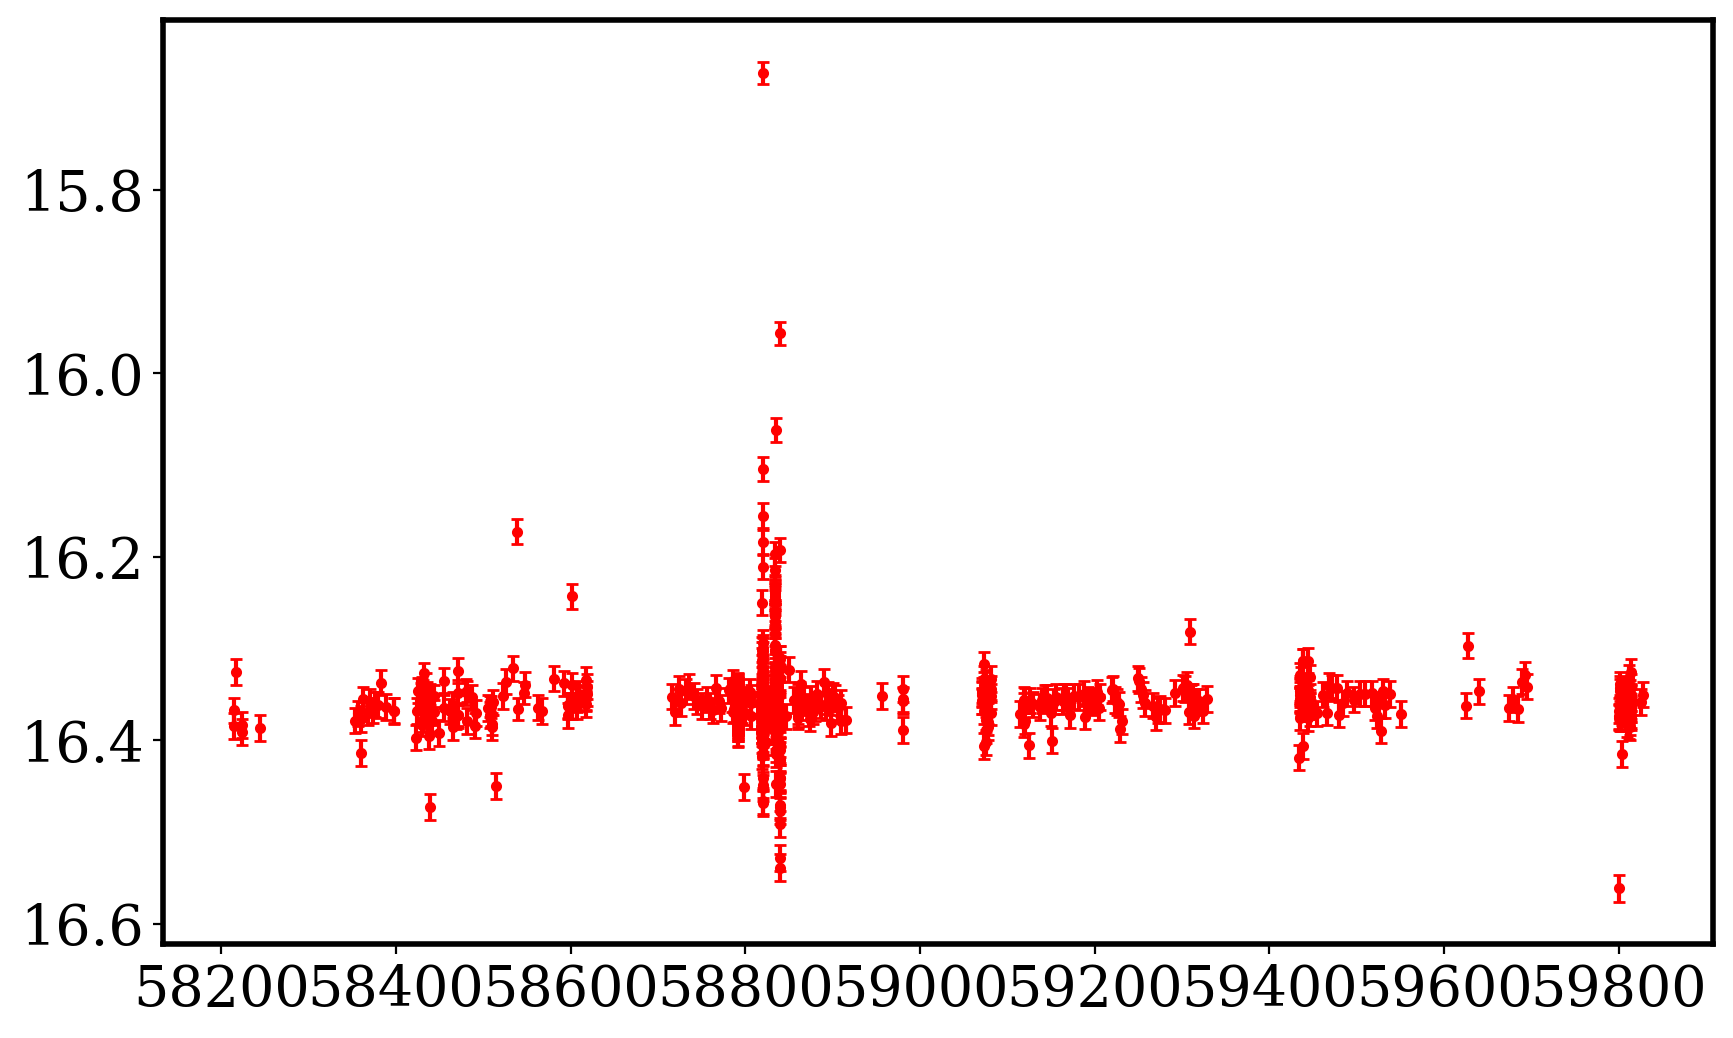

In [ ]:
rband = ts.data[ts.band=='r']

plt.figure(figsize=(10, 6))
plt.errorbar(rband.mjd_ztf_zource, rband.mag_ztf_zource, yerr=rband.magerr_ztf_zource, color='r', fmt='.', capsize=2)
plt.ylim(plt.ylim()[::-1])



## Calculating Time-Series Features

In [ ]:
%pip list | grep cesium

cesium               0.12.1
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from cesium import featurize

In [ ]:
features_to_use = ['amplitude',
                'percent_beyond_1_std',
                'maximum',
                'median',
                'median_absolute_deviation',
                'percent_close_to_median',
                'minimum',
                'skew',
                'std',
                'weighted_average', 
                "flux_percentile_ratio_mid20", 
                "flux_percentile_ratio_mid35",
                "flux_percentile_ratio_mid50",
                "flux_percentile_ratio_mid65",
                "flux_percentile_ratio_mid80",
                "stetson_j",
                  "stetson_k"]

In [ ]:
def compute_features(time, mag, magerr, flag, band, custom_cols=features_to_use):
    
    rmv = (flag == 0) & (~np.isnan(flag)) &  (band=='r') & (~np.isnan(mag)) & (~np.isnan(magerr)) & (magerr < 99) & (mag < 99)

    # Removed flagged data points
    time_, mag_, magerr_ = time[rmv], mag[rmv], magerr[rmv]

    # Compute features
    summary_ = {}

    if len(time_) > 0: 
        fset_cesium = featurize.featurize_time_series(
        times=time_,
        values=mag_,
        errors=magerr_,
        features_to_use=custom_cols)
    else:
        fset_cesium = pd.Series(list(np.zeros(len(features_to_use))), index=custom_cols) 
    
    return pd.Series(fset_cesium.values[0], index=custom_cols) 


In [ ]:
# Define DataFrame with loc and scale as meta
my_meta = pd.DataFrame(columns=features_to_use, dtype=float)

In [ ]:
_sources

,Teff-P_golden_golden_x_ztf_dr14,RA_ICRS_golden_golden_x_ztf_dr14,DE_ICRS_golden_golden_x_ztf_dr14,logg-P_golden_golden_x_ztf_dr14,Lum-F_golden_golden_x_ztf_dr14,Norder_golden_golden_x_ztf_dr14,Dir_golden_golden_x_ztf_dr14,Npix_golden_golden_x_ztf_dr14,ps1_objid_ztf_dr14_golden_x_ztf_dr14,nobs_r_ztf_dr14_golden_x_ztf_dr14,nobs_g_ztf_dr14_golden_x_ztf_dr14,ra_ztf_dr14_golden_x_ztf_dr14,dec_ztf_dr14_golden_x_ztf_dr14,_dist_arcsec_golden_x_ztf_dr14,ra_ztf_zource,dec_ztf_zource,mjd_ztf_zource,mag_ztf_zource,magerr_ztf_zource,band_ztf_zource,ps1_objid_ztf_zource,catflags_ztf_zource
npartitions=23,,,,,,,,,,,,,,,,,,,,,,
6759058615752982528,float64,float64,float64,float64,float64,uint8,uint64,uint64,int64,int32,int32,float64,float64,float64,float64,float64,float64,float32,float32,string,int64,int16
6759340090729693184,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6768628764961144832,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18446744073709551615,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [ ]:
%%time
# apply calc_biweight function
calc_ = ens.batch(
    compute_features,
    'mjd_ztf_zource', 'mag_ztf_zource', 
    'magerr_ztf_zource', 'catflags_ztf_zource',
    'band_ztf_zource',
    meta=my_meta,
    use_map=True)

Using generated label, result_1, for a batch result.
CPU times: user 5.62 ms, sys: 4.38 ms, total: 10 ms
Wall time: 9.9 ms


In [ ]:
%%time
#ens.object.join(calc_).update_ensemble()

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.39 µs


In [ ]:
%%time
new_table = calc_.compute()

CPU times: user 3.95 s, sys: 724 ms, total: 4.67 s
Wall time: 1min 30s


In [ ]:
new_table

,amplitude,percent_beyond_1_std,maximum,median,median_absolute_deviation,percent_close_to_median,minimum,skew,std,weighted_average,flux_percentile_ratio_mid20,flux_percentile_ratio_mid35,flux_percentile_ratio_mid50,flux_percentile_ratio_mid65,flux_percentile_ratio_mid80,stetson_j,stetson_k
_hipscat_index,,,,,,,,,,,,,,,,,
6759861235694436352,0.052757,0.274924,16.418705,16.361895,0.008821,0.589124,16.313190,0.048448,0.014154,16.361353,0.146970,0.269720,0.397893,0.551996,0.743753,-0.989740,0.962813
6762483210258481152,0.060066,0.255814,17.033401,16.985670,0.012396,0.488372,16.913269,-0.597125,0.022151,16.982361,0.140068,0.214612,0.356626,0.473270,0.693780,-0.973225,0.944264
6762597460679327744,0.111551,0.295638,17.396904,17.321072,0.015787,0.662359,17.173801,-0.468346,0.024618,17.319266,0.170836,0.289530,0.416222,0.558207,0.786740,-0.966274,0.975627
6763056230786138112,0.088201,0.273621,16.215702,16.119698,0.010773,0.727135,16.039301,0.050355,0.017467,16.119739,0.144471,0.260029,0.378466,0.523540,0.733181,-0.984028,0.960818
6763105036554731520,0.047082,0.317460,14.725718,14.667343,0.008973,0.534392,14.631554,0.476860,0.012829,14.668046,0.167918,0.290467,0.446868,0.616877,0.765362,-0.991552,0.980090
6763786659667378176,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6763563429186764800,0.065872,0.304598,16.734638,16.667658,0.012453,0.514368,16.602894,0.107560,0.018547,16.668498,0.150180,0.268961,0.420216,0.572699,0.769507,-0.982200,0.987091
6764043431367933952,0.054981,0.252747,15.668400,15.629448,0.011406,0.494505,15.558437,-0.362726,0.019008,15.627881,0.155377,0.244235,0.344195,0.498578,0.661446,-0.980893,0.963381
6763859177497427968,0.070125,0.279710,16.589800,16.511481,0.012045,0.563768,16.449551,0.047531,0.018359,16.511944,0.139847,0.256841,0.402043,0.544798,0.729620,-0.982505,0.974077


In [ ]:
#%%timea
#calc_.to_parquet("test/features_ztf")

In [ ]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 2,Total memory: 24.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44369,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 2
Started: 3 minutes ago,Total memory: 24.00 GiB
Comm: tcp://127.0.0.1:38665,Total threads: 1
Dashboard: http://127.0.0.1:39217/status,Memory: 12.00 GiB
Nanny: tcp://127.0.0.1:34713,
